In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# model

In [3]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, base=64):
        super().__init__()

        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, base, 3, padding=1),
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(base, base * 2, 3, stride=2, padding=1),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv2d(base * 2, base * 2, 3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(base * 2, base, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.out = nn.Conv2d(base, in_channels, 1)

    def forward(self, x, t):
        # t ignored in simple Fast-DDPM variant
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.middle(x2)
        x4 = self.up1(x3)
        return self.out(x4)

In [10]:
# diffusion - Fast DDPM
class FastDDPM(nn.Module):
    def __init__(self, timesteps=50, beta_start=1e-4, beta_end=0.02):
        super().__init__()

        self.T = timesteps

        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1.0 - betas
        alpha_bars = torch.cumprod(alphas, dim=0)

        # Register as buffers
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alpha_bars", alpha_bars)

    def q_sample(self, x0, t, noise):
        alpha_bar = self.alpha_bars[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise

    def p_sample(self, model, x, t):
        beta = self.betas[t]
        alpha = self.alphas[t]
        alpha_bar = self.alpha_bars[t]

        noise_pred = model(x, t)
        mean = (1 / torch.sqrt(alpha)) * (
            x - beta / torch.sqrt(1 - alpha_bar) * noise_pred
        )

        if t == 0:
            return mean

        noise = torch.randn_like(x)
        return mean + torch.sqrt(beta) * noise

# train

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [13]:
dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = SimpleUNet().to(device)
diffusion = FastDDPM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    pbar = tqdm(loader)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, diffusion.T, (x.size(0),), device=device)
        noise = torch.randn_like(x)

        x_noisy = diffusion.q_sample(x, t, noise)
        noise_pred = model(x_noisy, t)

        loss = torch.mean((noise - noise_pred) ** 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch} Loss {loss.item():.4f}")

torch.save(model.state_dict(), "fast_ddpm.pth")

Epoch 4 Loss 0.0731: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 51.55it/s]


# Image generation

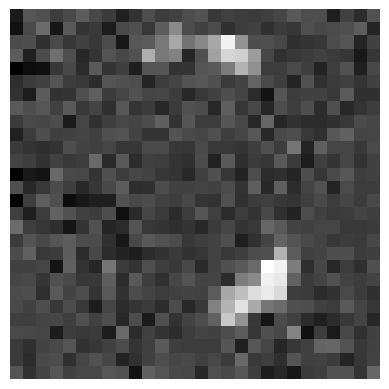

In [19]:
import matplotlib.pyplot as plt

model = SimpleUNet().to(device)
model.load_state_dict(torch.load("fast_ddpm.pth", map_location=device))
model.eval()

diffusion = FastDDPM()
x = torch.randn(1, 1, 28, 28).to(device)

with torch.no_grad():
    for t in reversed(range(diffusion.T)):
        x = diffusion.p_sample(model, x, t)

plt.imshow(x.squeeze().cpu(), cmap="gray")
plt.axis("off")
plt.show()

In [20]:
# test case (fast DDPM)
def test_forward_pass():
    model = SimpleUNet()
    diffusion = FastDDPM()

    x = torch.randn(2, 1, 28, 28)
    t = torch.randint(0, diffusion.T, (2,))
    noise = torch.randn_like(x)

    x_noisy = diffusion.q_sample(x, t, noise)
    noise_pred = model(x_noisy, t)

    assert noise_pred.shape == x.shape
    print("✓ Forward pass test passed")

def test_reverse_step():
    model = SimpleUNet()
    diffusion = FastDDPM()

    x = torch.randn(1, 1, 28, 28)
    x_prev = diffusion.p_sample(model, x, t=10)

    assert x_prev.shape == x.shape
    print("✓ Reverse diffusion step passed")

In [21]:
test_forward_pass()
test_reverse_step()

✓ Forward pass test passed
✓ Reverse diffusion step passed
